In [1]:
# %pip install gymnasium

In [2]:
# %pip install torch

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import gymnasium as gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random


# Environment

In [5]:
class ChargingEnv(gym.Env):

    def __init__(self, render_mode=None, battery_capacity = 50, alpha = [1,1,1,1,1,1,1,1]):
        
        super(ChargingEnv, self).__init__()
        
        self.battery_capacity = battery_capacity  # The capacity of the battery
        self.alpha = alpha  # The price coefficients per interval
        self.num_intervals = 8 # 15-minute intervals in 2 hours
        self.mu = 30 # expected energy demand
        self.sigma = 5 # sd of energy demand
        
        # Action space: 4 different charging rates, 0 (no charge), 1 (low charge), 2 (medium charge), 3 (high charge)
        self.action_space = spaces.Discrete(4)
        
        ##Observation space: SoC (continuous), Time Step (discrete)
        self.observation_space = spaces.Tuple((
           spaces.Box(low=0, high=self.battery_capacity, dtype=np.float32),
           spaces.Discrete(self.num_intervals)
        ))
        
        # Initialize SoC for the very first episode
        initial_demand = np.random.normal(self.mu, self.sigma)
        initial_demand = np.clip(initial_demand, 0, self.battery_capacity)
        self.residual_soc = self.battery_capacity - initial_demand # SoC from episode before, assuming it was a full battery minus one working day
        self.soc = self.residual_soc
        
        self.time_step = 0
    
        # Metrics
        self.action_frequency = np.zeros(self.action_space.n)
        self.actions_per_time_step = {f'time_step_{i}': np.zeros(self.action_space.n) for i in range(self.num_intervals)}  # Initialize as dictionary
        self.total_recharge_cost = 0.0
        self.energy_demand = 0.0
        self.residual_energy = 0.0
        self.energy_added = 0.0
        self.missing_energy = 0.0
        self.penalty_count = 0
        self.reward = 0

    
    def reset(self):
        """Reset the environment to the initial state for a new day."""
        self.soc = self.residual_soc  # Start with the residual SoC from the previous day
        self.time_step = 0

        # Reset metrics for next episode
        self.action_frequency = np.zeros(self.action_space.n)
        self.actions_per_time_step = {f'time_step_{i}': np.zeros(self.action_space.n) for i in range(self.num_intervals)}  # Initialize as dictionary
        self.total_recharge_cost = 0.0
        self.energy_demand = 0.0
        self.residual_energy = 0.0
        self.cumu_energy_added = 0.0
        self.missing_energy = 0.0
        self.penalty_count = 0
        self.reward = 0
        
        return self._get_observation()
    
    def step(self, action):
        """Execute one time step within the environment."""
        assert self.action_space.contains(action), f"{action} is an invalid action"

        charging_rates = [0, 7, 15, 22]  # kW
        charging_rate = charging_rates[action]

        energy_added = min(charging_rate * 0.25, self.battery_capacity - self.soc)  # 15 minutes is 0.25 hours, ensure SoC does not exceed battery capacity
        self.cumu_energy_added += energy_added
        self.soc = self.soc + energy_added
        
        cost =  self._calculate_cost(charging_rate)
        self.reward -= cost
        
        done = self.time_step+1 >= self.num_intervals # Check if charging window is over
        if done:
            self.reward = self._calculate_end_of_day_reward()

        # Update metrics
        self.action_frequency[action] += 1
        self.actions_per_time_step[f'time_step_{self.time_step}'][action] += 1

        self.total_recharge_cost += cost # cost based on charging rate not actual energy charged
        
        self.time_step += 1
        
        observation = self._get_observation()
        return observation, self.reward, done, {}


    def _get_observation(self):
        """Get the current observation."""
        return (np.array([self.soc], dtype=np.float32), self.time_step)

    def _calculate_cost(self, charging_rate):
        """Calculate the charging cost based on the exponential function."""
        alpha_t = self.alpha[self.time_step]  # coefficient for time based price
        return alpha_t * np.exp(charging_rate)
    
    def _calculate_end_of_day_reward(self):
        """Calculate the reward at the end of the day."""
        self.energy_demand = np.random.normal(self.mu, self.sigma)
        if self.soc < self.energy_demand:
            self.missing_energy = self.energy_demand - self.soc
            penalty = np.exp(22) * 8 * min(1, self.missing_energy) # penalty for not meeting demand is worse than charging fully for 8 timesteps, proportional to missing demand        
            self.reward-= penalty
            self.residual_soc = 0  # Not enough charge, set residual SoC to 0
            self.penalty_count += 1
        else:
            self.missing_energy = 0
            self.residual_soc = self.soc - self.energy_demand  # Update residual SoC for the next day
        
        return self.reward

    def report_metrics(self):
        """Report the metrics at the end of an episode."""
        metrics = {
            "action_frequency": self.action_frequency,
            "actions_per_time_step": self.actions_per_time_step,
            "energy_demand": self.energy_demand,
            "residual_energy": self.residual_soc,
            "energy_added": self.cumu_energy_added,
            "missing_energy": self.missing_energy,
            "total_recharge_cost": self.total_recharge_cost,
            "penalty_count": self.penalty_count,
            "reward": self.reward
        }
        return metrics

## Basic Example


ep_2_residual_energy = ep_1_residual_energy + ep_2_energy_added - ep_2_energy demand  
logic: residual episode 1 energy after charging and demand, now in episode 2 we charge and subtract demand

In [8]:
env = ChargingEnv()

# simple fixed policy
def fixed_policy(state):
    return 2  # Always choose the medium charging rate

num_episodes = 10
for episode in range(num_episodes):
    
    state = env.reset()
    done = False
    while not done: # does 8 time steps
        action = fixed_policy(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
    # After each episode, print the metrics
    metrics = env.report_metrics()
    print(f"Episode {episode + 1}: {metrics}")


Episode 1: {'action_frequency': array([0., 0., 8., 0.]), 'actions_per_time_step': {'time_step_0': array([0., 0., 1., 0.]), 'time_step_1': array([0., 0., 1., 0.]), 'time_step_2': array([0., 0., 1., 0.]), 'time_step_3': array([0., 0., 1., 0.]), 'time_step_4': array([0., 0., 1., 0.]), 'time_step_5': array([0., 0., 1., 0.]), 'time_step_6': array([0., 0., 1., 0.]), 'time_step_7': array([0., 0., 1., 0.])}, 'energy_demand': 28.221175808926965, 'residual_energy': 21.661417298009603, 'energy_added': 30.0, 'missing_energy': 0, 'total_recharge_cost': 26152138.979776885, 'penalty_count': 0, 'reward': -26152138.979776885}
Episode 2: {'action_frequency': array([0., 0., 8., 0.]), 'actions_per_time_step': {'time_step_0': array([0., 0., 1., 0.]), 'time_step_1': array([0., 0., 1., 0.]), 'time_step_2': array([0., 0., 1., 0.]), 'time_step_3': array([0., 0., 1., 0.]), 'time_step_4': array([0., 0., 1., 0.]), 'time_step_5': array([0., 0., 1., 0.]), 'time_step_6': array([0., 0., 1., 0.]), 'time_step_7': array

# Double DQN

In [10]:
class DDQN(nn.Module):
    # Neural Network of two fully connected layers with 128 neurons followed by output layer with number of possible actions as output dimension
    # approximates q values for each action and updates these using backpropagation of loss when calculating expected q value using bellman-equation
    
    def __init__(self, input_dim, output_dim):
        """Initializes NN with layers."""
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        """Execute forward pass."""
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

    
class ReplayBuffer:
    # store and sample experiences to break correlation between consecutive experiences
    def __init__(self, capacity):
        """Initialize replay buffer with max capacity."""
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add an experience tuple to buffer."""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Sample a batch of experiences from buffer."""
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done
    
    def __len__(self):
        """Return current size of buffer."""
        return len(self.buffer)


In [11]:
def train_ddqn(env, model, target_model, replay_buffer, optimizer, batch_size, gamma):
    """Implement DDQN training loop."""
    
    # check if replay buffer has enough experience to sample full batch
    if len(replay_buffer) < batch_size:
        return
    
    # sample a batch
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    # convert to tensors since model requires tensor inputs
    state = torch.FloatTensor(np.array(state))
    action = torch.LongTensor(np.array(action))
    reward = torch.DoubleTensor(np.array(reward))
    next_state = torch.FloatTensor(np.array(next_state))
    done = torch.FloatTensor(np.array(done))
    
    q_values = model(state) # compute this states q values for all actions with current network
    next_q_values = model(next_state) #  compute next states q values for all actions with current network
    next_q_state_values = target_model(next_state) # compute next states q values for all actions with target network
    
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1) # get q value for action taken
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1) # get the action maximizing next states q value using the current network but evaluate the q value using the target network -> DDQN
    expected_q_value = reward + gamma * next_q_value * (1 - done) # compute target q-value using bellman equation
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean() # detach to prevent target network from receiving gradients and updates during training step of current network
    
    # backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## Train the model

In [20]:
def run_ddqn_model(env, buffer_size=10000, batch_size=64, gamma=0.9, epsilon=1.0, 
                     epsilon_decay=0.998, min_epsilon=0.01, num_episodes=5000, update_target_every=10):
    """
    Train a DDQN model on the provided environment.

    Args:
        env: The environment to train on.
        buffer_size: The size of the replay buffer.
        batch_size: The size of the minibatch for training.
        gamma: The discount factor.
        epsilon: The starting value for epsilon in the epsilon-greedy policy.
        epsilon_decay: The decay rate of epsilon after each episode.
        min_epsilon: The minimum value that epsilon can decay to.
        num_episodes: The number of episodes to train for.
        update_target_every: The number of episodes after which the target network is updated.
    """
    
    input_dim = env.observation_space[0].shape[0] + 1  # size of box + 1 for discrete as input of observation space
    output_dim = env.action_space.n  # output dimension is number of possible actions

    model = DDQN(input_dim, output_dim)  # current Q-network
    target_model = DDQN(input_dim, output_dim)  # target Q-network
    target_model.load_state_dict(model.state_dict())  # copy starting weights from current to target Q-network

    optimizer = optim.Adam(model.parameters())
    replay_buffer = ReplayBuffer(buffer_size)

    all_metrics = []

    for episode in range(num_episodes):
        state = env.reset()
        state = np.hstack((state[0], state[1]))  # flatten the state tuple into a single array

        total_reward = 0
        done = False

        # while one episode of 8 time steps is not done
        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()  # exploration
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    q_values = model(state_tensor)
                    action = q_values.max(1)[1].item()  # exploitation

            # execute action in environment
            next_state, reward, done, _ = env.step(action)
            next_state = np.hstack((next_state[0], next_state[1]))  # flatten the next state tuple

            # store experience
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # train the DDQN
            train_ddqn(env, model, target_model, replay_buffer, optimizer, batch_size, gamma)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        if episode % update_target_every == 0:
            target_model.load_state_dict(model.state_dict())  # every 'update_target_every' episodes update target network
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")

        # collect episode metrics
        metrics = env.report_metrics()
        metrics['episode'] = episode
        all_metrics.append(metrics)

    # collect all metrics in a dataframe
    metrics_df = pd.DataFrame(all_metrics)
    action_frequency_df = pd.DataFrame(metrics_df['action_frequency'].tolist(), columns=[f'action_{i}' for i in range(output_dim)])  # flatten action frequency 
    metrics_df = pd.concat([metrics_df.drop(columns=['action_frequency']), action_frequency_df], axis=1)

    actions_per_time_step_df = pd.DataFrame(metrics_df['actions_per_time_step'].tolist())  # flatten actions chosen per time step 
    for col in actions_per_time_step_df.columns:
        actions_per_time_step_df[col] = actions_per_time_step_df[col].apply(lambda x: list(x).index(1))

    metrics_df = pd.concat([metrics_df.drop(columns=['actions_per_time_step']), actions_per_time_step_df], axis=1)

    return metrics_df, model


env = ChargingEnv()
metrics_df, model = run_ddqn_model(env, gamma=0.8, epsilon=1.0, epsilon_decay=0.998, num_episodes=5000)


Episode: 0, Total Reward: -46620213200.206215, Epsilon: 0.998
Episode: 10, Total Reward: -53806400414.82913, Epsilon: 0.9782186852652456
Episode: 20, Total Reward: -68146046317.18971, Epsilon: 0.9588294551122902
Episode: 30, Total Reward: -93207752643.18506, Epsilon: 0.9398245380496356
Episode: 40, Total Reward: -64551314370.97595, Epsilon: 0.9211963166241796
Episode: 50, Total Reward: -71740760733.27293, Epsilon: 0.9029373243680279
Episode: 60, Total Reward: -50218213075.15928, Epsilon: 0.8850402428058224
Episode: 70, Total Reward: -28725071225.53366, Epsilon: 0.867497898521388
Episode: 80, Total Reward: -53790050950.43414, Epsilon: 0.8503032602825207
Episode: 90, Total Reward: -35849137260.38119, Epsilon: 0.8334494362227647
Episode: 100, Total Reward: -64528440021.433914, Epsilon: 0.8169296710790511
Episode: 110, Total Reward: -46672522948.33156, Epsilon: 0.800737343484087
Episode: 120, Total Reward: -53822734540.35991, Epsilon: 0.7848659633124138
Episode: 130, Total Reward: -2874143

In [21]:
metrics_df

,energy_demand,residual_energy,energy_added,missing_energy,total_recharge_cost,penalty_count,reward,episode,action_0,action_1,action_2,action_3,time_step_0,time_step_1,time_step_2,time_step_3,time_step_4,time_step_5,time_step_6,time_step_7
0,28.266855,21.733145,19.696809,0.000000,1.075801e+10,0,-1.075801e+10,0,3.0,1.0,1.0,3.0,0,0,3,2,3,3,0,1
1,33.698692,16.301308,28.266855,0.000000,1.792784e+10,0,-1.792784e+10,1,0.0,2.0,1.0,5.0,3,1,1,3,3,2,3,3
2,33.206603,10.844704,27.750000,0.000000,1.076455e+10,0,-1.076455e+10,2,2.0,0.0,3.0,3.0,3,2,2,3,3,0,2,0
3,24.978997,9.865707,24.000000,0.000000,1.076128e+10,0,-1.076128e+10,3,3.0,0.0,2.0,3.0,0,3,2,3,0,0,3,2
4,28.545508,1.570200,20.250000,0.000000,1.307936e+07,0,-1.307936e+07,4,1.0,3.0,4.0,0.0,1,2,0,1,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,28.024729,3.529709,30.000000,0.000000,2.615214e+07,0,-2.615214e+07,4995,0.0,0.0,8.0,0.0,2,2,2,2,2,2,2,2
4996,35.654298,0.000000,30.000000,2.124589,2.615214e+07,1,-2.870545e+10,4996,0.0,0.0,8.0,0.0,2,2,2,2,2,2,2,2
4997,33.701517,0.000000,30.000000,3.701517,2.615214e+07,1,-2.870545e+10,4997,0.0,0.0,8.0,0.0,2,2,2,2,2,2,2,2
4998,26.569497,3.430503,30.000000,0.000000,2.615214e+07,0,-2.615214e+07,4998,0.0,0.0,8.0,0.0,2,2,2,2,2,2,2,2


## Evaluating the model

### Running Averages

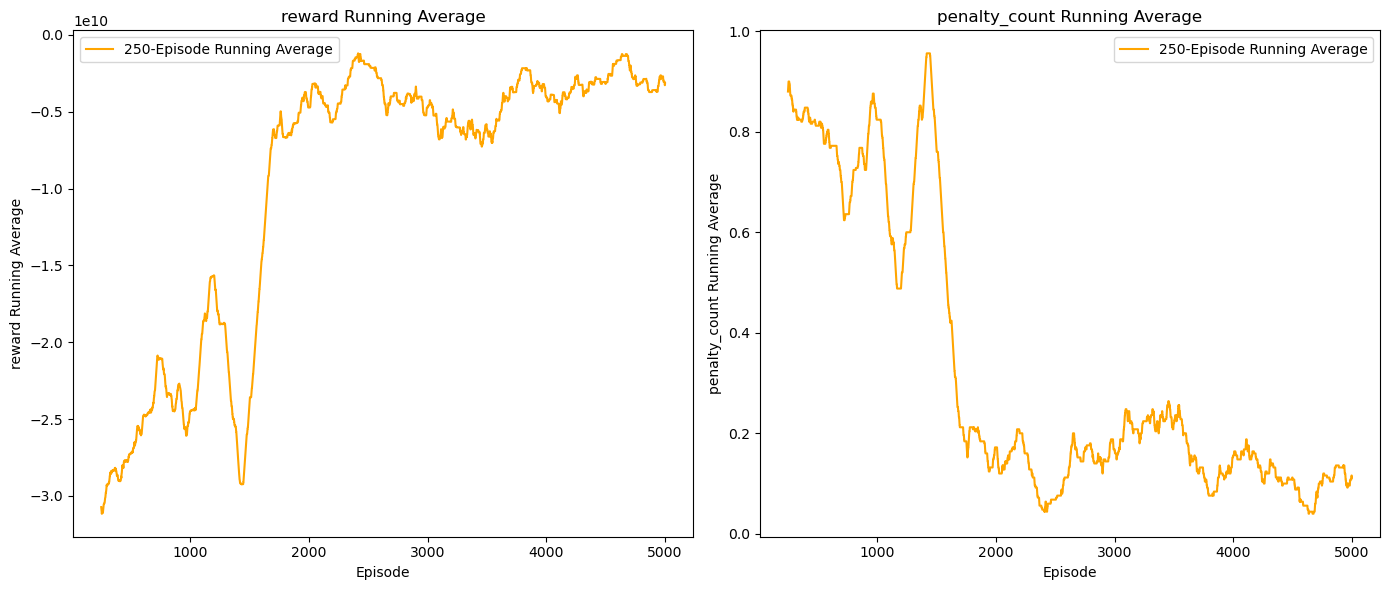

In [24]:
def running_average(metrics_df, column, window_size=250, ax=None):
    """Plot Running Average for given Metric"""
    metrics_df[f"{column}_running_avg"] = metrics_df[column].rolling(window=window_size).mean() # average over rolling window size

    ax.plot(metrics_df['episode'], metrics_df[f"{column}_running_avg"], label=f'{window_size}-Episode Running Average', color='orange')
    ax.set_xlabel('Episode')
    ax.set_ylabel(f"{column} Running Average")
    ax.set_title(f"{column} Running Average")
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

running_average(metrics_df, 'reward', window_size=250, ax=axes[0])
running_average(metrics_df, 'penalty_count', window_size=250, ax=axes[1])

plt.tight_layout() 
plt.show()


We can see that the reward increases until around episode 2000 where the model stabilizes and mostly exploits the learned policy. The penalty count also decreases until around episode 2000. 

### Episodic Development of Action Frequency 

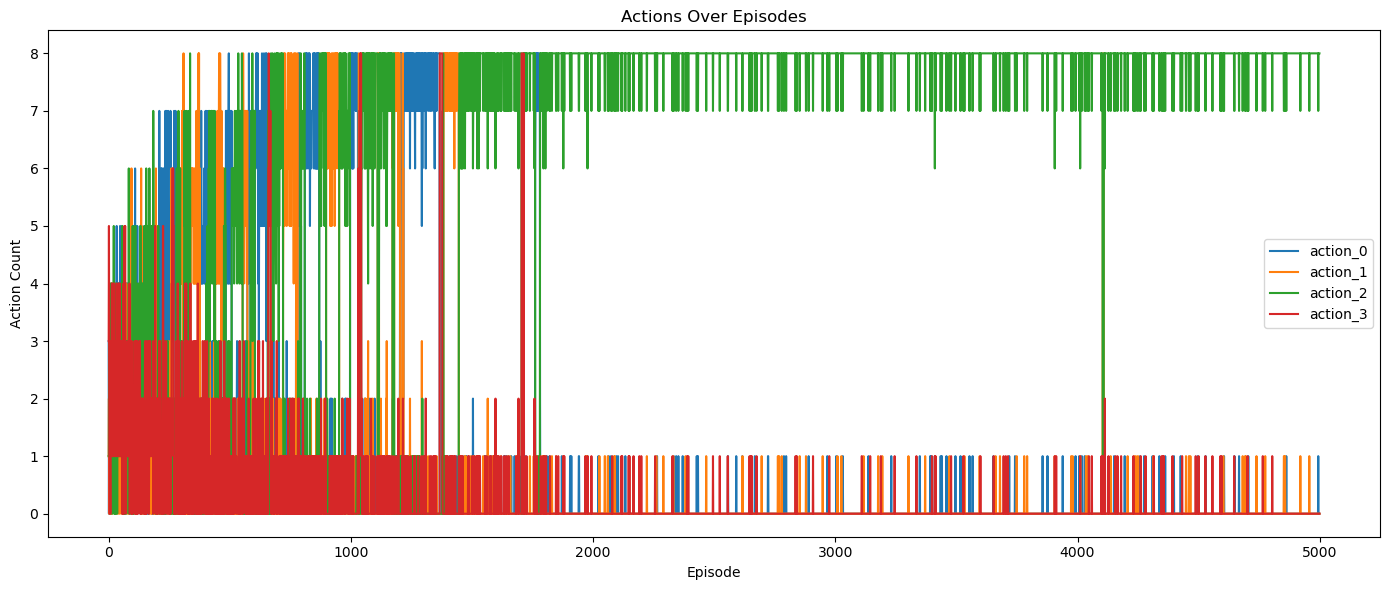

In [27]:
def plot_all_actions(metrics_df, ax):
    """Plot Action Frequency over all Episodes on axis."""
    
    action_columns = ['action_0', 'action_1', 'action_2', 'action_3']
    for action in action_columns:
        ax.plot(metrics_df['episode'], metrics_df[action], label=action)

    ax.set_xlabel('Episode')
    ax.set_ylabel('Action Count')
    ax.set_title('Actions Over Episodes')
    ax.legend()


fig, ax = plt.subplots(figsize=(14, 6))

plot_all_actions(metrics_df, ax)

plt.tight_layout()  
plt.show()


The model learns to mostly charge with 15 kWh (action 2) and infrequently explore other actions.

### Time Step Frequencies

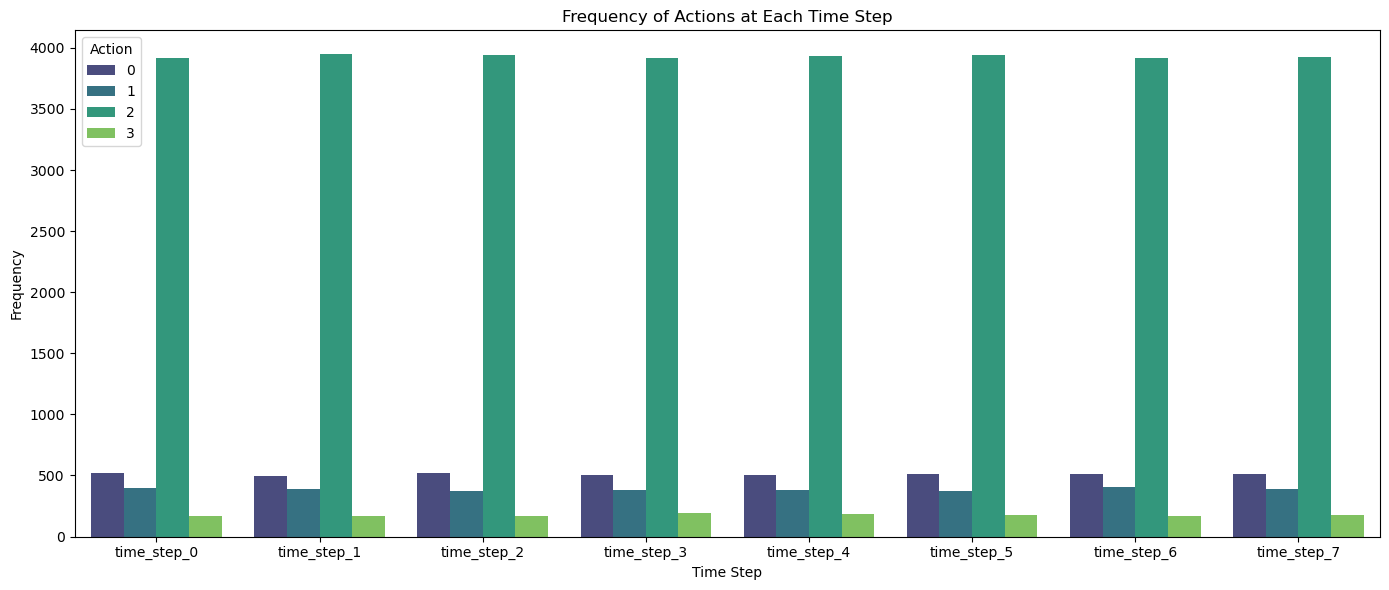

In [30]:
def plot_time_step_frequencies(metrics_df, ax):
    """Plot Time Step Frequency on axis."""

    # melt the df from wide to long format
    melted_df = metrics_df[['time_step_0', 'time_step_1',
           'time_step_2', 'time_step_3', 'time_step_4', 'time_step_5',
           'time_step_6', 'time_step_7']].melt(var_name='time_step', value_name='action', value_vars=[f'time_step_{i}' for i in range(8)])

    # calculate the frequency of each action for each time step
    frequency_df = melted_df.groupby(['time_step', 'action']).size().reset_index(name='count')

    sns.barplot(x='time_step', y='count', hue='action', data=frequency_df, palette='viridis')

    plt.xlabel('Time Step')
    plt.ylabel('Frequency')
    plt.title('Frequency of Actions at Each Time Step')
    plt.legend(title='Action')
    
    
fig, ax = plt.subplots(figsize=(14, 6))

plot_time_step_frequencies(metrics_df, ax)

plt.tight_layout()  
plt.show()


The model does not distinguish between time steps of the observation space and has a uniform distribution for each action across time steps.

### Q-Values

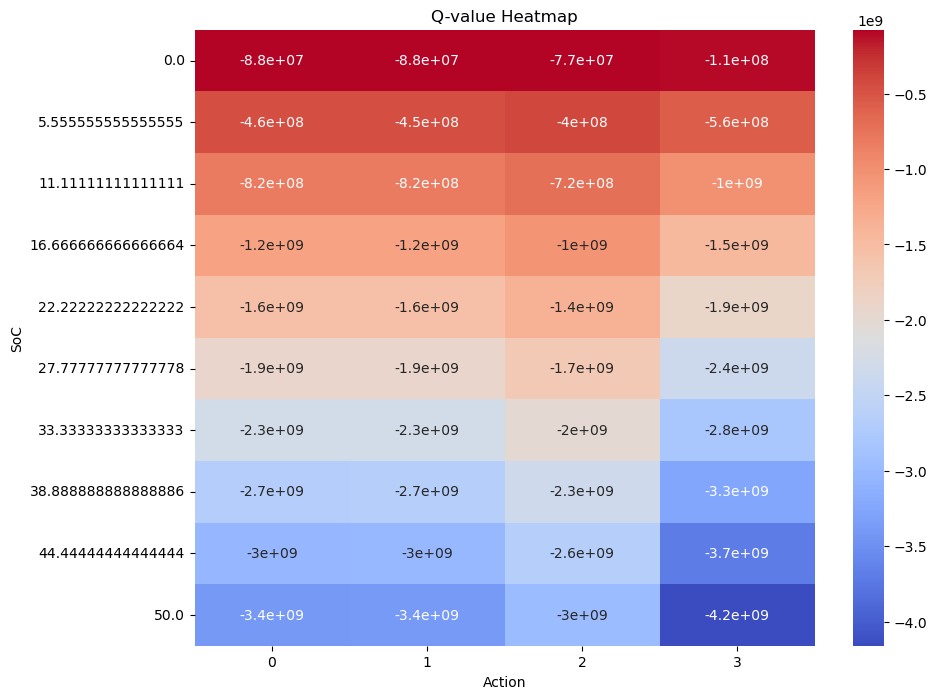

In [33]:
def plot_q_value_heatmap(model, soc_values, actions):
    """Plot Q-Values of the specified model across different SoC values and the action space."""
    
    q_values_matrix = np.zeros((len(soc_values), len(actions))) # matrix to store the Q-values for each SoC and action

    # iterate over each SoC value to calculate the Q-values
    for i, soc in enumerate(soc_values):

        # assuming the time step is fixed at 0 
        state = [soc, 0]
        
        # convert state to a tensor 
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        # use the model to predict Q-values for the current state

        with torch.no_grad():
            q_values = model(state_tensor).squeeze().numpy()  # get the Q-values and convert to numpy array

        # store the Q-values corresponding to SoC value
        q_values_matrix[i, :] = q_values

    plt.figure(figsize=(10, 8))
    
    sns.heatmap(q_values_matrix, annot=True, cmap='coolwarm', xticklabels=actions, yticklabels=soc_values)
    
    plt.xlabel('Action')
    plt.ylabel('SoC')
    plt.title('Q-value Heatmap')
    
    plt.show()

soc_values = np.linspace(0, 50, 10)  # SoC values between 0 and 50
actions = [0, 1, 2, 3] 
plot_q_value_heatmap(model, soc_values, actions)  


For all of the SoC values, the Q-Value is lowest for action 2. This leads to the model mostly choosing action 2 in each time step. Action 0 has a slightly lower Q-Value than 1 and 3, possibly due to the lower immediate cost when charging. This heatmap represents the Q-Values that our learned network predicts for the different actions at different SoCs.

### Tabular Evaluation

In [36]:
def summary_table(metrics_df):
    """
    Calculate the total reward, total number of penalties, and the percentages of actions.

    Args:
        metrics_df (pd.DataFrame): The input DataFrame containing columns for reward, penalty_count, and action counts.

    Returns:
        dict: A dictionary containing the total reward, total penalties, and total counts of each action.
    """                                  
                                                  
    summary = {
    'total_reward': metrics_df['reward'].sum(),
    'total_missed_days': metrics_df['penalty_count'].sum(),
    'perc_action_0': metrics_df['action_0'].sum()/(8*len(metrics_df)),
    'perc_action_1': metrics_df['action_1'].sum()/(8*len(metrics_df)),
    'perc_action_2': metrics_df['action_2'].sum()/(8*len(metrics_df)),
    'perc_action_3': metrics_df['action_3'].sum()/(8*len(metrics_df))
    }
    
    summary_df = pd.DataFrame([summary])

    return summary_df

summary_df = summary_table(metrics_df)
summary_df


,total_reward,total_missed_days,perc_action_0,perc_action_1,perc_action_2,perc_action_3
0,-5.091445e+13,1647,0.1022,0.077025,0.785925,0.03485
